In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

result = llm.invoke("What is the capital of France?")
result.content

'The capital of France is Paris.'

In [4]:
from typing import TypedDict
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str # boolean value

In [6]:
# schema for structured output to use in evaluation
from pydantic import BaseModel, Field
from typing import Literal
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not"
        )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it"
        )


evaluator = llm.with_structured_output(Feedback)
    


In [8]:
# Node
def llm_call_generator(state: State):
    """Generate a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
            )
    else:
        msg = llm.invoke(f"write a joke about {state['topic']}")

    return {"joke": msg.content}

In [9]:
def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke: {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

In [10]:
# Conditional edge function to route back to joke generator or end based upon feedback
# from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + feedback"

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


In [12]:
# Build Workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("generator", llm_call_generator)
optimizer_builder.add_node("evaluator", llm_call_evaluator)

# Add edges between nodes
optimizer_builder.add_edge(START, "generator")
optimizer_builder.add_edge("generator", "evaluator")
optimizer_builder.add_conditional_edges("evaluator", route_joke,
{
    "Accepted": END,
    "Rejected + feedback": "generator",
}
)

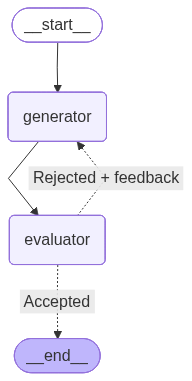

In [13]:
# compile the workflow
optimizer_workflow = optimizer_builder.compile()
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [14]:
# Invoke the workflow
result = optimizer_workflow.invoke({"topic": "quantum computing"})
print(result["joke"])

Why did the quantum computer break up with its partner?

Because it couldn't handle the superposition of their feelings!
